### Importing Libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Cleaning Dataset


1.   Loading and Reading the Dataset
2.   Removing unnecessary data
3.   Renaming Columns for better understanding
4. Removing Null values and Overshoots




In [30]:
df = pd.read_csv("survey_results_public.csv")
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [31]:
df.shape

(64461, 61)

In [32]:
df = df[['Country' , 'EdLevel' , 'YearsCodePro' , 'Employment' , 'ConvertedComp']]
df = df.rename({'ConvertedComp' : 'Salary'} , axis = 1)
df = df[df['Employment']=='Employed full-time']
df = df.drop('Employment' , axis = 1)

In [33]:
## Various ways of dealing with NaN slots but as we have ample data we will skip on all the null entries

# 1 -> df = df[df['Salary'].notnull()]
# 2 -> df.fillna(df.mean(numeric_only=True).round(1), inplace=True)
df = df.dropna()
df.head()

,Country,EdLevel,YearsCodePro,Salary
7,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,116000.0
9,United Kingdom,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,32315.0
10,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,40070.0
11,Spain,Some college/university study without earning ...,7,14268.0
12,Netherlands,"Secondary school (e.g. American high school, G...",20,38916.0


In [34]:
## Dealing with Categories with very few entries so that our model does not get confused
def shorten (categories , threshold):
  category_map = {}
  for i in range (len(categories)):
    if categories.values[i] >= threshold:
      category_map[categories.index[i]] = categories.index[i]
    else :
      category_map[categories.index[i]] = 'Other'
  return category_map

In [35]:
# Combining Countries with few entries
country_map = shorten(df.Country.value_counts() , 400)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Other                 8549
United States         7569
India                 2425
United Kingdom        2287
Germany               1903
Canada                1178
Brazil                 991
France                 972
Spain                  670
Australia              659
Netherlands            654
Poland                 566
Italy                  560
Russian Federation     522
Sweden                 514
Name: Country, dtype: int64

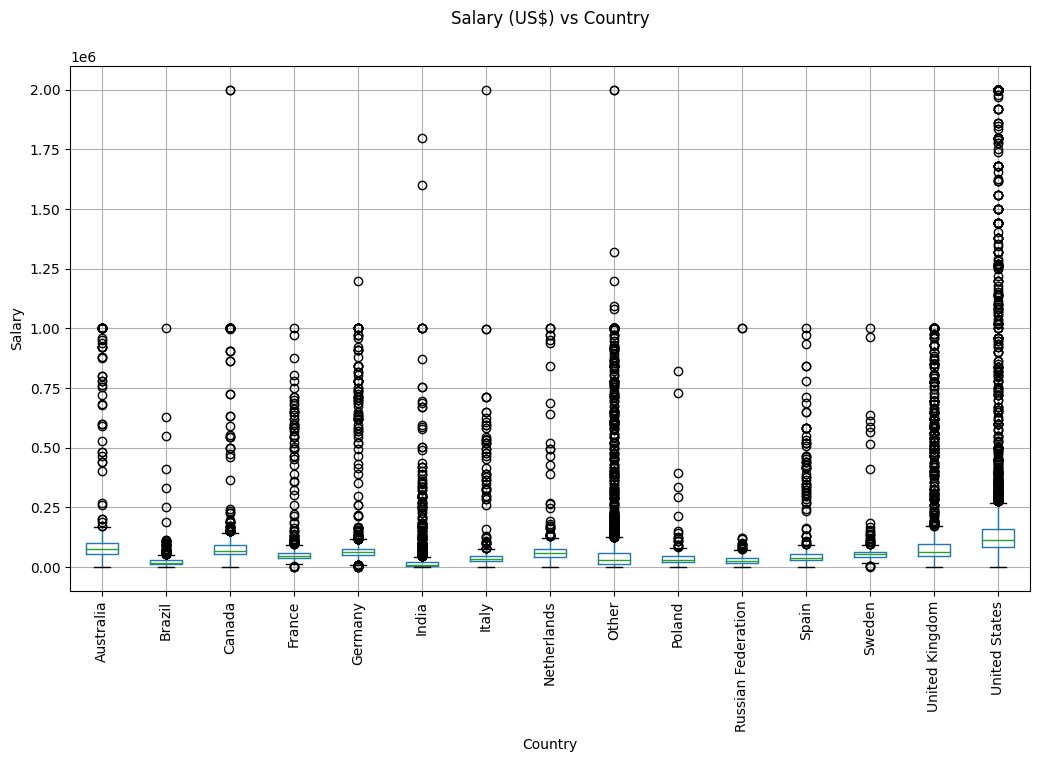

In [36]:
# Visualizing the entries to know about outliers
fig , ax = plt.subplots(1,1 , figsize = (12,7))
df.boxplot('Salary' , 'Country' , ax = ax )
plt.suptitle('Salary (US$) vs Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 90)
plt.show()

In [37]:
#Removing the Outliers
df = df[df['Salary'] <= 250000]
df = df[df['Salary'] >= 10000]
df = df[df['Country'] != 'Other']

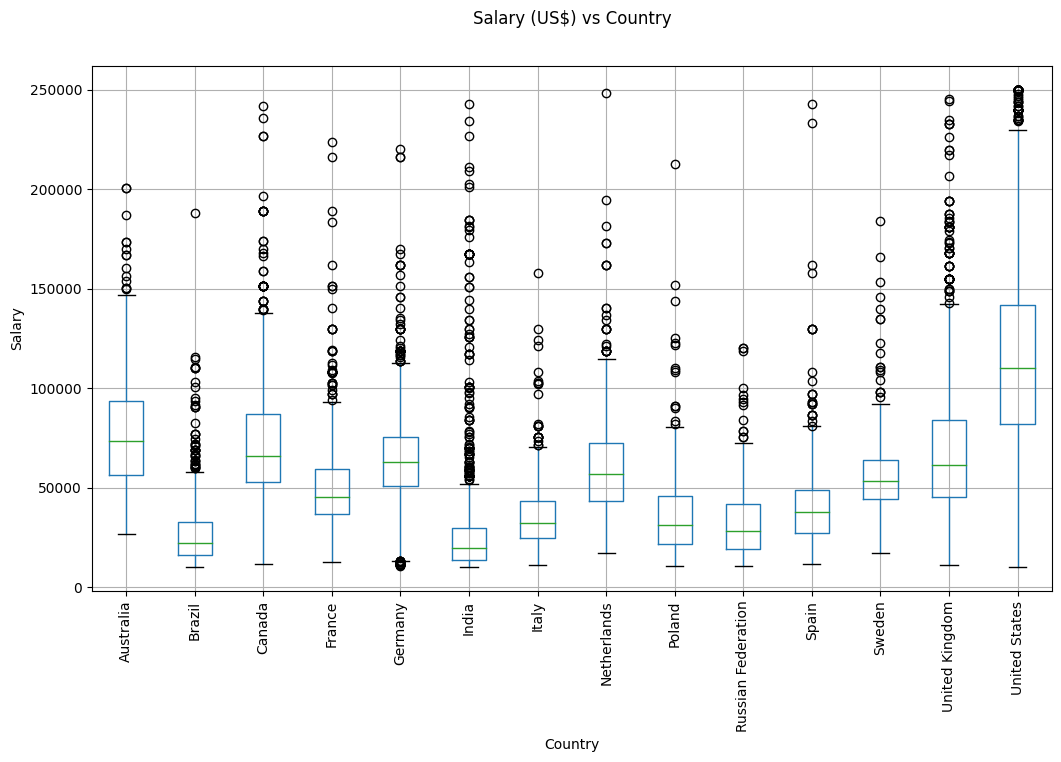

In [38]:
#Visualizing again to understand about the mean values and the distribution
fig , ax = plt.subplots(1,1 , figsize = (12,7))
df.boxplot('Salary' , 'Country' , ax = ax )
plt.suptitle('Salary (US$) vs Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 90)
plt.show()

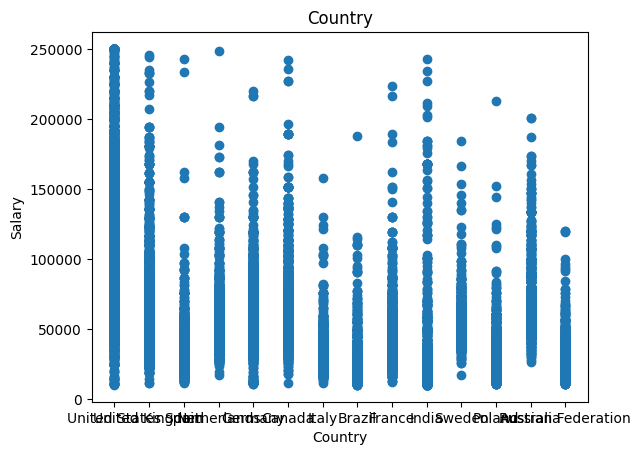

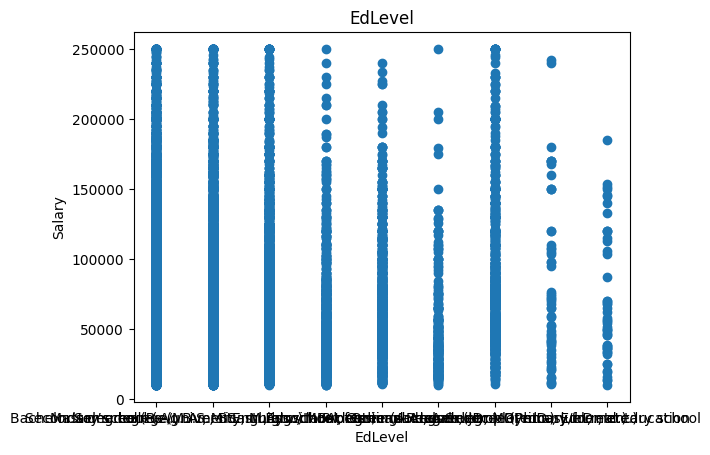

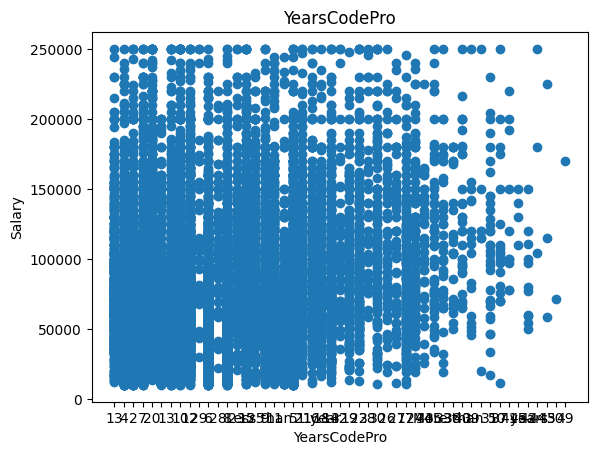

In [39]:
for label in df.iloc[:,:-1]:
  plt.scatter(df[label], df['Salary'])
  plt.title(label)
  plt.ylabel("Salary")
  plt.xlabel(label)
  plt.show()

### Preparing & Cleaning Dataset


1.   Altering Data to get uniform entries in each feature
2.   Encoding Entries and transforming data using sklearn -> LabelEncoder



In [40]:
df['YearsCodePro'].unique()

array(['13', '4', '2', '7', '20', '1', '3', '10', '12', '29', '6', '28',
       '8', '23', '15', '25', '9', '11', 'Less than 1 year', '5', '21',
       '16', '18', '14', '32', '19', '22', '38', '30', '26', '27', '17',
       '24', '34', '35', '33', '36', '40', '39', 'More than 50 years',
       '31', '37', '41', '45', '42', '44', '43', '50', '49'], dtype=object)

In [41]:
# to remove the abnormal entries like 'Less than 1 year' & 'More than 50 years'
def clean_experience(entry):
  if entry == 'More than 50 years':
    return 50
  if entry == 'Less than 1 year':
    return 0.5
  return float(entry)

In [42]:
df['YearsCodePro'] = df['YearsCodePro'].apply(clean_experience)
df['YearsCodePro'].unique()

array([13. ,  4. ,  2. ,  7. , 20. ,  1. ,  3. , 10. , 12. , 29. ,  6. ,
       28. ,  8. , 23. , 15. , 25. ,  9. , 11. ,  0.5,  5. , 21. , 16. ,
       18. , 14. , 32. , 19. , 22. , 38. , 30. , 26. , 27. , 17. , 24. ,
       34. , 35. , 33. , 36. , 40. , 39. , 50. , 31. , 37. , 41. , 45. ,
       42. , 44. , 43. , 49. ])

In [43]:
df['EdLevel'].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'I never completed any formal education',
       'Primary/elementary school'], dtype=object)

In [44]:
def clean_education (entry):
  if 'Bachelor’s degree' in entry:
    return 'Bachelor’s degree'
  if 'Master’s degree' in entry:
    return 'Master’s degree'
  if 'Professional degree' in entry or 'doctoral degree' in entry:
    return 'Post grad'
  return 'Less than a Bachelors'

In [45]:
df['EdLevel'] = df['EdLevel'].apply(clean_education)
df['EdLevel'].unique()

array(['Bachelor’s degree', 'Master’s degree', 'Less than a Bachelors',
       'Post grad'], dtype=object)

In [46]:
# Encoding the 4 different Education Levels into 4 different computationally friendly forms
encoded_education = LabelEncoder()
df['EdLevel'] = encoded_education.fit_transform(df['EdLevel'])
df['EdLevel'].unique()

array([0, 2, 1, 3])

In [47]:
# Similarly with the Country
encoded_country = LabelEncoder()
df['Country'] = encoded_country.fit_transform(df['Country'])
df['Country'].unique()

array([13, 12, 10,  7,  4,  2,  6,  1,  3,  5, 11,  8,  0,  9])

### Start Training our Model

In [48]:
df.head()

,Country,EdLevel,YearsCodePro,Salary
7,13,0,13.0,116000.0
9,12,2,4.0,32315.0
10,12,0,2.0,40070.0
11,10,1,7.0,14268.0
12,7,1,20.0,38916.0


In [60]:
X = df.drop(['Salary'] , axis = 1)
y = df[['Salary']]

In [62]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 0)

In [65]:
model = LinearRegression()
model.fit(X_train , y_train)

LinearRegression()

In [66]:
y_pred = model.predict(X_test)

In [70]:
accuracy_train = model.score(X_train , y_train)
accuracy_train

0.31678065739833305

In [71]:
accuracy_test = model.score(X_test , y_test)
accuracy_test

0.3506567642385181

In [ ]:
import tensorflow as tf

nn_model = tf.keras.Sequential()
nn_model.add(tf.keras.layers.Dense(32 , activation = 'relu') )
nn_model.add(tf.keras.layers.Dropout(0.2))
nn_model.add(tf.keras.layers.Dense(16, activation = 'relu'))
nn_model.add(tf.keras.layers.Dense(1))

nn_model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss='mae')

nn_model.fit(X_train , y_train ,epochs = 128 , verbose = 2 , validation_split = 0.2)

In [97]:
y_pred = nn_model.predict(X_test)
error = np.sqrt(mean_squared_error(y_pred , y_test))
error

116/116 [==============================] - 0s 763us/step


39263.40873943987

In [98]:
import pickle
data = {"model": nn_model, "le_country": encoded_country, "le_education": encoded_education}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)


In [99]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

regressor_loaded = data["model"]
le_country = data["le_country"]
le_education = data["le_education"]


In [100]:
y_pred = regressor_loaded.predict(X_test)
error = np.sqrt(mean_squared_error(y_pred , y_test))
error

116/116 [==============================] - 0s 749us/step


39263.40873943987